# Baseline Model

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (IndexLocator, FormatStrFormatter, AutoMinorLocator)
%matplotlib inline

conso = pd.read_csv('Ressources/Consommation des ménages trimestrielle.csv',sep=';')
conso = conso.set_index('Période').replace({',':'.'},regex=True).astype('float64')
conso.index = pd.to_datetime(conso.index.str.replace('T1','-03-31').str.replace('T2','-06-30').str.replace('T3','-09-30').str.replace('T4','-12-31'))

yty_var = conso['TOTAL ']/conso['TOTAL '].shift(periods=4) - 1

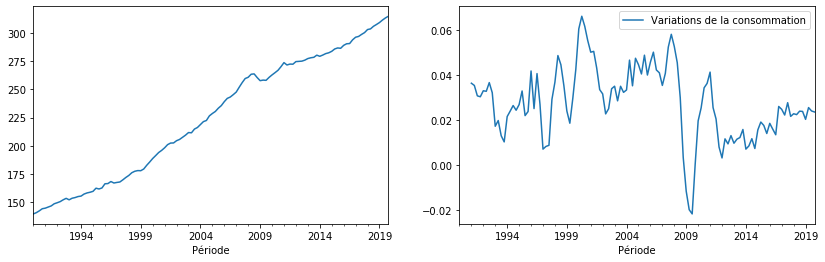

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
conso['TOTAL '].plot(ax=ax1,label='Dépenses de consommationd des ménages')
yty_var.plot(ax=ax2,label='Variations de la consommation')
plt.legend()
plt.show()

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

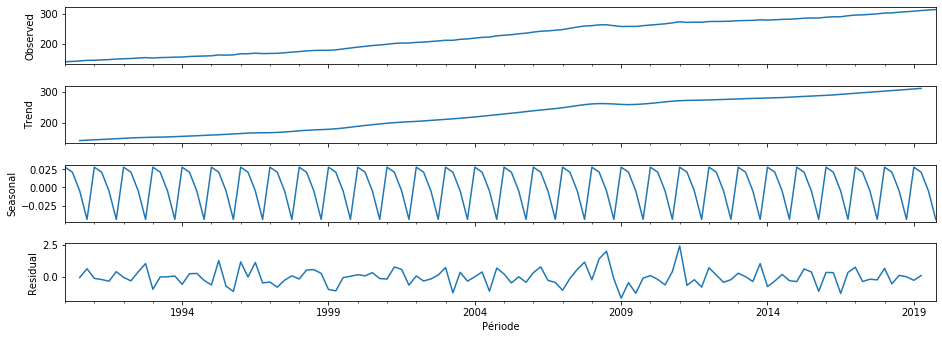

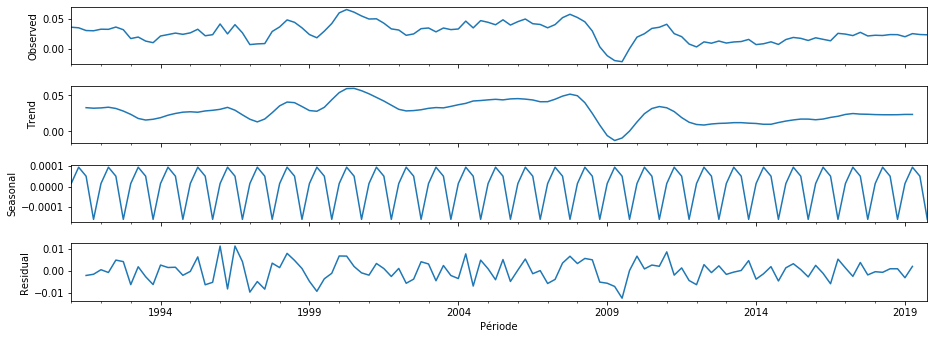

In [6]:
fig = seasonal_decompose(conso['TOTAL ']).plot()

fig.set_size_inches(15,5)

fig2 = seasonal_decompose(yty_var.dropna()).plot()
fig2.set_size_inches(15,5)

plt.show()

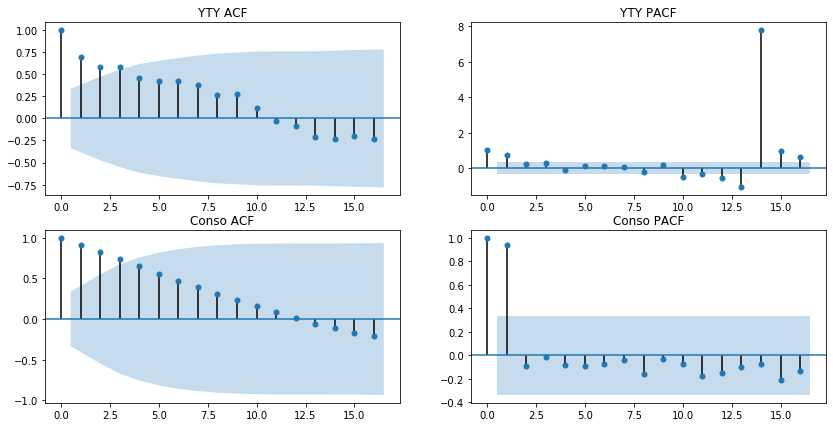

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig2, axes2 = plt.subplots(2,2, figsize=(14,7))
plot_acf(yty_var.loc['2011-09-30':], ax=axes2[0][0], title="YTY ACF")
plot_pacf(yty_var.loc['2011-09-30':], ax=axes2[0][1], title="YTY PACF")
plot_acf(conso['TOTAL '].loc['2011-09-30':],ax=axes2[1][0], title="Conso ACF")
plot_pacf(conso['TOTAL '].loc['2011-09-30':],ax=axes2[1][1], title="Conso PACF")
plt.show()

Nous pouvons donc d'abord envisager un ARMA(1,3)

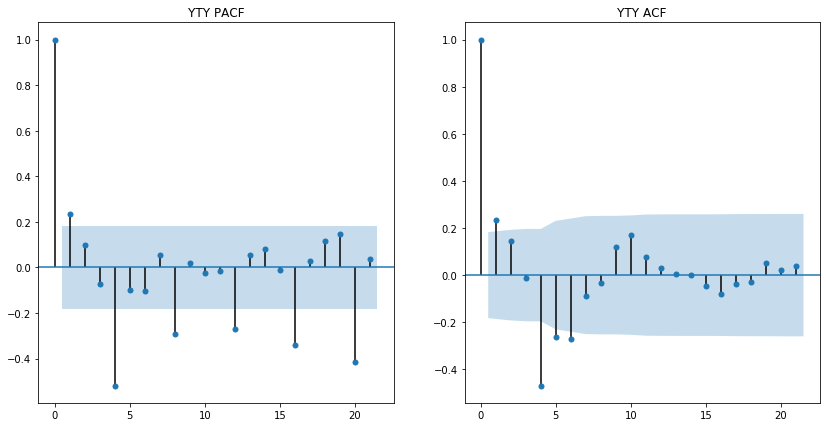

In [8]:
Y = conso['TOTAL '].diff(periods=4).diff(periods=1) # Modèle ARMA associé au SARIMA
fig2, axes2 = plt.subplots(1,2, figsize=(14,7))
plot_acf(Y.dropna(), ax=axes2[1], title="YTY ACF")
plot_pacf(Y.dropna(), ax=axes2[0], title="YTY PACF")
plt.show()

On peut tenter un SARIMA(1,1,1)(1,1,3)

In [9]:
import statsmodels.api as sm

In [10]:
SARIMA1 = sm.tsa.SARIMAX(conso['TOTAL '], order=(1,1,1), seasonal_order=(1,1,3,4)).fit()
print(SARIMA1.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
                                 Statespace Model Results                                
Dep. Variable:                            TOTAL    No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 3, 4)   Log Likelihood                -197.128
Date:                           Sat, 25 Apr 2020   AIC                            408.256
Time:                                   11:47:58   BIC                            427.470
Sample:                               03-31-1990   HQIC                           416.055
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----

In [11]:
predict = SARIMA1.get_prediction()
predict_ci = predict.conf_int()

predict_dy = SARIMA1.get_prediction(dynamic='2011-03-31')
predict_dy_ci = predict_dy.conf_int()

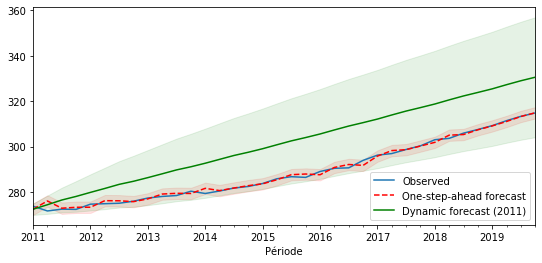

In [12]:
fig, ax = plt.subplots(figsize=(9,4))

conso['TOTAL '].loc['2011-03-31':].plot(ax=ax, label='Observed')

predict.predicted_mean.loc['2011-03-31':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2011-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

predict_dy.predicted_mean.loc['2011-03-31':].plot(ax=ax, style='g', label='Dynamic forecast (2011)')
ci = predict_dy_ci.loc['2011-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

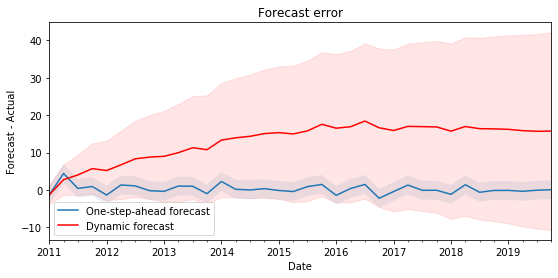

In [13]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))

ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

predict_error = predict.predicted_mean - conso['TOTAL ']
predict_error.loc['2011-03-31':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc['2011-03-31':].copy()
ci.iloc[:,0] -= conso['TOTAL '].loc['2011-03-31':]
ci.iloc[:,1] -= conso['TOTAL '].loc['1977-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

predict_dy_error = predict_dy.predicted_mean - conso['TOTAL ']
predict_dy_error.loc['2011-03-31':].plot(ax=ax, style='r', label='Dynamic forecast')
ci = predict_dy_ci.loc['2011-03-31':].copy()
ci.iloc[:,0] -= conso['TOTAL '].loc['2011-03-31':]
ci.iloc[:,1] -= conso['TOTAL '].loc['2011-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')

## ARMA sur la variable yty_var

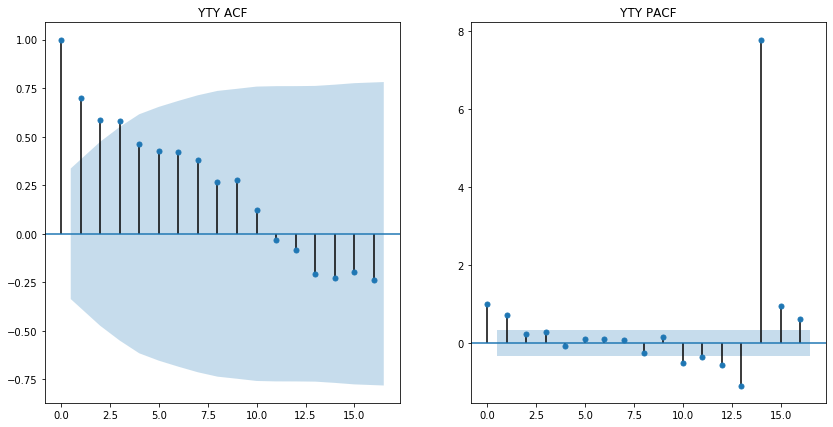

In [14]:
fig3, axes3 = plt.subplots(1,2, figsize=(14,7))
plot_acf(yty_var.loc['2011-09-30':], ax=axes3[0], title="YTY ACF")
plot_pacf(yty_var.loc['2011-09-30':], ax=axes3[1], title="YTY PACF")
plt.show()

Comme les données sont CVS, et qu'on a différencié en yty, la série est à peu près stationnaire.

On remarque une très forte autocorrélation partielle avec t-14 (pas tout le temps faisable...), mais aussi t-13 et t-1. Il y a aussi une forte autocorrélation avec t-1, t-2 et t-3.

On peut ainsi convenir d'un ARMA(3,1) ou d'un ARMA(3,14).

In [15]:
ARMA1 = sm.tsa.SARIMAX(yty_var, order=(3,0,1)).fit()
print(ARMA1.summary())

Statespace Model Results                           
Dep. Variable:                 TOTAL    No. Observations:                  120
Model:               SARIMAX(3, 0, 1)   Log Likelihood                 389.153
Date:                Sat, 25 Apr 2020   AIC                           -768.306
Time:                        11:48:03   BIC                           -754.369
Sample:                    03-31-1990   HQIC                          -762.646
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7781      0.738      1.055      0.291      -0.668       2.224
ar.L2          0.3427      0.791      0.433      0.665      -1.207       1.893
ar.L3         -0.1869      0.119     -1.564      0.118      -0.421       0.047


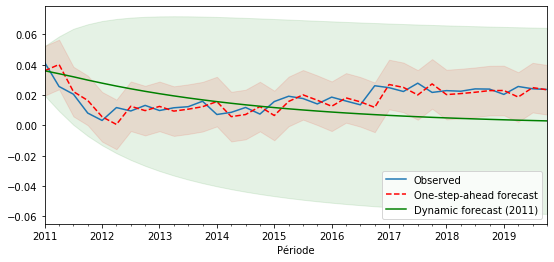

In [16]:
predict2 = ARMA1.get_prediction()
predict_ci2 = predict2.conf_int()

predict_dy2 = ARMA1.get_prediction(dynamic='2011-03-31')
predict_dy_ci2 = predict_dy2.conf_int()

fig2, ax2 = plt.subplots(figsize=(9,4))

yty_var.loc['2011-03-31':].plot(ax=ax2, label='Observed')

predict2.predicted_mean.loc['2011-03-31':].plot(ax=ax2, style='r--', label='One-step-ahead forecast')
ci2 = predict_ci2.loc['2011-03-31':]
ax2.fill_between(ci2.index, ci2.iloc[:,0], ci2.iloc[:,1], color='r', alpha=0.1)

predict_dy2.predicted_mean.loc['2011-03-31':].plot(ax=ax2, style='g', label='Dynamic forecast (2011)')
ci2 = predict_dy_ci2.loc['2011-03-31':]
ax2.fill_between(ci2.index, ci2.iloc[:,0], ci2.iloc[:,1], color='g', alpha=0.1)

legend = ax2.legend(loc='lower right')

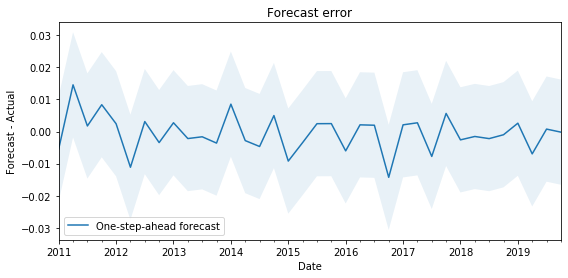

In [17]:
# Graph
fig4, ax4 = plt.subplots(figsize=(9,4))

ax4.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

predict_error2 = predict2.predicted_mean - yty_var
predict_error2.loc['2011-03-31':].plot(ax=ax4, label='One-step-ahead forecast')
ci2 = predict_ci2.loc['2011-03-31':].copy()
ci2.iloc[:,0] -= yty_var.loc['2011-03-31':]
ci2.iloc[:,1] -= yty_var.loc['1977-03-31':]
ax4.fill_between(ci2.index, ci2.iloc[:,0], ci2.iloc[:,1], alpha=0.1)

#predict_dy_error2 = predict_dy.predicted_mean - yty_var
#predict_dy_error2.loc['2011-03-31':].plot(ax=ax4, style='r', label='Dynamic forecast')
#ci2 = predict_dy_ci2.loc['2011-03-31':].copy()
#ci2.iloc[:,0] -= yty_var.loc['2011-03-31':]
#ci2.iloc[:,1] -= yty_var.loc['2011-03-31':]
#ax4.fill_between(ci2.index, ci2.iloc[:,0], ci2.iloc[:,1], color='r', alpha=0.1)

legend = ax4.legend(loc='lower left');
legend.get_frame().set_facecolor('w')

## Échantillonnage de données mélangées, sans contraintes
Unconstrained mixed data sampling - UMIDAS

Soit $t$ dénotant les mois. Les trimestres sont donc dénotés par $3t$. Les séries doivent être stationnaires.

\begin{align*}

Y_{3t} = \alpha + \Phi(B)Y_{3t} + \beta(B)X_{3t}^{'} + \epsilon_t
\\
\text{où :} 
\left\{\begin{array} \, X_t = & (X_{1,t}, \cdots, X_{k,t})
\\
\Phi(B) = & \sum_{i=1}^{p} \Phi_i B^{3i}
\\
\beta(B) = & (\sum_{i=0}^{3p} \beta_{i,1} B^i , \cdots, \sum_{i=0}^{3p} \beta_{i,k} B^i)
\end{array} \right.

\end{align*}

Estimation par MCO : 

\begin{align*}

\hat{\alpha}_{MCO}, \hat{\Phi}_{MCO},\hat{\beta}_{MCO} = \underset{\alpha, \Phi, \beta}{arg min} \sum_{t=p}^T (Y_{3t} - \alpha - \Phi(B)Y_{3t} - \beta(B)X_{3t}^{'})^2

\end{align*}

En posant : 

\begin{align*}

Z_{3t} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})

\end{align*}

Le problème se réécrit :

\begin{align*}

\underset{\omega \in \mathbb{R}^{1 + p + k(3p+1)}}{arg min} \sum_{t=p}^{T} (Y_{3t} - \omega Z_{3t}^{'} )^2

\end{align*}

Il y a une solution explicite :

\begin{align*}

\hat{\omega}_{MCO} = \mathbb{E}[Z_{3t}^{'} Z_{3t}]^{-1} \mathbb{E}[Z_{3t}^{'}Y_{3t}] \approx (\sum_{t=p}^T Z_{3t}^{'} Z_{3t})^{-1} \sum_{t=p}^TZ_{3t}^{'}Y_{3t}

\end{align*}

Ainsi la prévision nowcast devient :

\begin{align*}

\hat{Y}_{3t + 3} = \hat{\omega}_{MCO} Z_{3t + 3}^{'}

\end{align*}

### Que fait-on lorsque nous n'avons pas tous les mois du trimestre ?

Les données passent de $Z_{3t} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})$ à $Z_{3t,mois} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t} \mathbb{1}_{\% 3 \leq mois}(3t),X_{1,3t-1}\mathbb{1}_{\% 3 \leq mois}(3t - 1),\cdots, X_{1,3t-3p} \mathbb{1}_{\% 3 \leq mois}(3t-3p),X_{2,3t} \mathbb{1}_{\% 3 \leq mois}(3t),\cdots, X_{k,3t-3p}\mathbb{1}_{\% 3 \leq mois}(3t-3p))$ où \% désigne le reste de la division euclidienne, et où une valeur constante nulle signifie une absence de donnée.

Une idée peut être de d'abord faire une régression (AR(3p)) des mois suivants en fonction des mois précédents de chaque variable explicative.

On prévoit alors ainsi :

\begin{align*}

\hat{Y}_{3t + 3} = \hat{\omega}_{MCO} \tilde{Z}_{3t + 3}^{'}

\end{align*}

avec $\tilde{Z}_{3t + 3}^{'}$ le vecteur $Z_{3t,mois}$ où l'on a remplacé les zéros par la prédiction par AR(3p) des valeurs manquantes.

In [72]:
''' Upload et sélection des données '''

selection = ["Fabrication d’autres équipements électriques, situation actuelle de l’état du carnet de commandes en fin de mois",
"Activités informatiques et services d’information, prévisions d’évolution de la demande globale à 1 mois",
"Activités informatiques et services d’information, évolution des prix par rapport au mois précédent",
"Information et communication, évolution de l’activité par rapport au mois précédent",
"Produits en plastique, évolution du prix des produits finis par rapport au mois précédent",
"Fabrication d’équipements électriques, taux moyen d’utilisation des capacités de production",
"Industries agricoles et alimentaires, prévisions du prix des produits finis à 1 mois",
"Équipements électriques et électroniques, autres machines, taux moyen d’utilisation des capacités de production"]

goods = pd.read_csv('Ressources/Goods index.csv',sep=';').drop(range(6))
services = pd.read_csv('Ressources/Services index.csv',sep=';').drop(range(4))
retail_trade = pd.read_csv('Ressources/Retail trade index.csv',sep=';').drop(range(4)).reset_index().drop('index',axis=1)

services = services.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64').loc['Déc 2019':'Mar 2010'].reset_index()
goods = goods.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64').loc[:'01/03/2010'].reset_index()
goods['Date']=services['Date']
retail_trade = retail_trade.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')[:-1:].loc[:'Mar 2010'].reset_index()
retail_volume=retail_trade.filter(regex='indice en volume')
retail_volume['Date']=services['Date']

indices=retail_volume.merge(goods, on="Date").merge(services,on="Date").set_index('Date')
indices_CVS = indices.loc[:,[column.endswith('CVS)') for column in indices.columns]].iloc[::-1].drop('Mar 2010')
indices_brut = indices.loc[:,[column.endswith('(Brut)') for column in indices.columns]].iloc[::-1].drop('Mar 2010')
Y = yty_var.loc['2010-04-30':]

In [81]:
''' Calcul de omega '''

p = 4 # On fixe l'ordre de régression p, il faudrait enquêter sur les autocorrélations
k = len(indices_brut.columns)

Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
for t in np.arange(p,len(Y)):
    z = [1]
    for i in range(p): # On rajoute les Y_(t-i)
        z.append(Y.iloc[3*(t-i-1)])
    for j in range(k):
        for i in range(p+1):
            z.append(indices_brut.iloc[3*(t-i),:])
    Z[t] = z

Z
# Ensuite, on calcule pour chaque t la matrice de design

# On calcule également le produit Z_3t' par Y_3t

# On somme les matrices de design, on somme les produits

# On multiplie l'inverse de la somme des matrices de design par la somme des produits.

IndexError: single positional indexer is out-of-bounds

In [20]:
''' Calcul des AR(p) '''

' Calcul des AR(p) '